In [15]:
import os
import glob
import yaml
import cv2

import importlib
import _pickle as pkl

import numpy as np
import pandas as pd
import pylab as pl

import plotting as putil
import dlc as dlc

In [16]:
plot_style='dark'
putil.set_sns_style(style=plot_style)
bg_color='w' if plot_style=='dark' else 'k'

In [17]:
%matplotlib notebook

In [18]:
def get_cmap(n, name="hsv"):
    """Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.
    https://github.com/DeepLabCut/DeepLabCut/blob/a61211dea445b664364c5befe5400dcbae9d577d/deeplabcut/utils/visualization.py#L33
    """
    return pl.cm.get_cmap(name, n)

def Histogram(vector, color, bins, ax=None, linewidth=1.0):
    '''
    https://github.com/DeepLabCut/DeepLabCut/blob/a61211dea445b664364c5befe5400dcbae9d577d/deeplabcut/utils/plotting.py#L48
    '''
    dvector = np.diff(vector)
    dvector = dvector[np.isfinite(dvector)]
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(dvector, color=color, histtype="step", bins=bins, linewidth=linewidth)

# Load dataset

In [7]:
rootdir = '/mnt/minerva/courtship-free-behavior/maDLCv2' #maDLCv2'
projectname = 'MMFv2'

experiment = 'MF-20mm-cantons-RL'
projectdir = os.path.join(rootdir, projectname) 

# load config file
cfg_fpath = os.path.join(projectdir, 'config.yaml')
with open(cfg_fpath, "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

# get list of tracked files
srcdir = os.path.join(projectdir, experiment)
suffix = 'el_IDcorrected'
tracked_files = glob.glob(os.path.join(srcdir, '*', '*_{}.h5'.format(suffix)))
print(len(tracked_files))

13


In [8]:
fn = tracked_files[0]
curr_figid = os.path.splitext(os.path.split(fn)[-1])[0]

print(fn)

df0 = pd.read_hdf(fn)
df0.head()

/mnt/minerva/courtship-free-behavior/maDLCv2/MMFv2/MF-20mm-cantons-RL/MF_030122_3/030122_Canton-S_age5_m_sh_f_gh_3DLC_dlcrnetms5_MMFv2Sep27shuffle1_200000_el_IDcorrected.h5


scorer      DLC_dlcrnetms5_MMFv2Sep27shuffle1_200000                       \
individuals                                     ind1                        
bodyparts                                    headTop                        
coords                                             x         y likelihood   
0                                            818.259  1094.121        1.0   
1                                            824.415  1086.117        1.0   
2                                            824.547  1081.190        1.0   
3                                            826.187  1076.055        1.0   
4                                            833.067  1075.237        1.0   

scorer                                                                         \
individuals                                                                     
bodyparts   thoraxCenter                      abdomenTop                        
coords                 x         y likelihood          x         y likelihood   
0                760.900  1078.966        1.0    739.500  1075.218        1.0   
1                767.248  1076.957        1.0    747.451  1071.435        1.0   
2                767.096  1072.299        1.0    749.076  1070.026        1.0   
3                771.710  1070.204        1.0    751.130  1065.949        1.0   
4                776.409  1071.546        1.0    753.440  1067.496        1.0   

scorer                     ...                                           \
individuals                ...        ind2                                
bodyparts   abdomenCenter  ... hindlegLeft hindlegRightJoint1             
coords                  x  ...  likelihood                  x         y   
0                 707.038  ...         1.0           1179.064  1091.572   
1                 713.780  ...         1.0           1179.209  1079.942   
2                 716.217  ...         1.0           1178.925  1066.698   
3                 715.125  ...         1.0           1173.835  1056.211   
4                 716.815  ...         1.0           1177.834  1019.732   

scorer                                                                       \
individuals                                                                   
bodyparts              hindlegRightJoint2                      hindlegRight   
coords      likelihood                  x         y likelihood            x   
0                  1.0           1177.358  1114.252        1.0     1194.526   
1                  1.0           1180.366  1114.151        1.0     1194.306   
2                  1.0           1181.617  1108.241        1.0     1194.751   
3                  1.0           1180.805  1100.845        1.0     1196.704   
4                  1.0           1182.196  1045.046        1.0     1194.969   

scorer                            
individuals                       
bodyparts                         
coords              y likelihood  
0            1169.741        1.0  
1            1169.870        1.0  
2            1169.028        1.0  
3            1159.887        1.0  
4            1095.543        1.0  

[5 rows x 174 columns]

In [11]:

bodyparts2plot = set(df0.columns.get_level_values("bodyparts"))
individuals = set(df0.columns.get_level_values("individuals"))

# PlottingReslts()

In [12]:
#  deeplabcut.plot_trajectories(config_path,['/fullpath/project/videos/reachingvideo1.avi'],filtered = True)

In [13]:
Dataframe = df0.copy()
individuals2plot = list(set(df0.columns.get_level_values("individuals")))
linewidth = 1.0

<IPython.core.display.Javascript object>


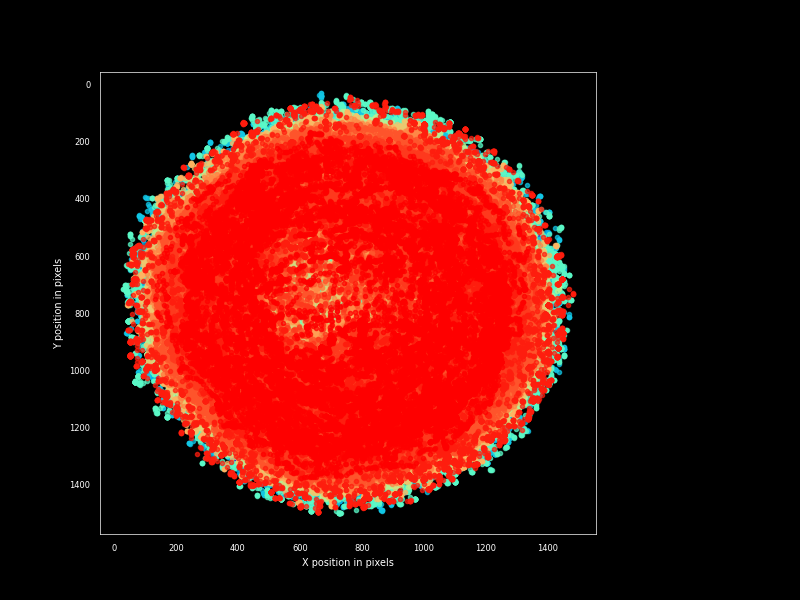

<IPython.core.display.Javascript object>


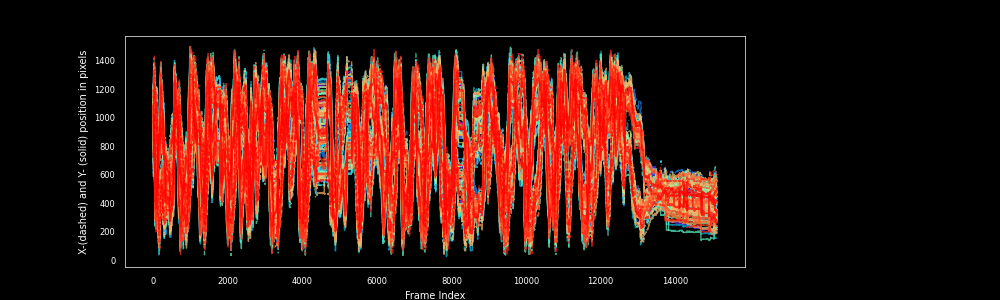

<IPython.core.display.Javascript object>


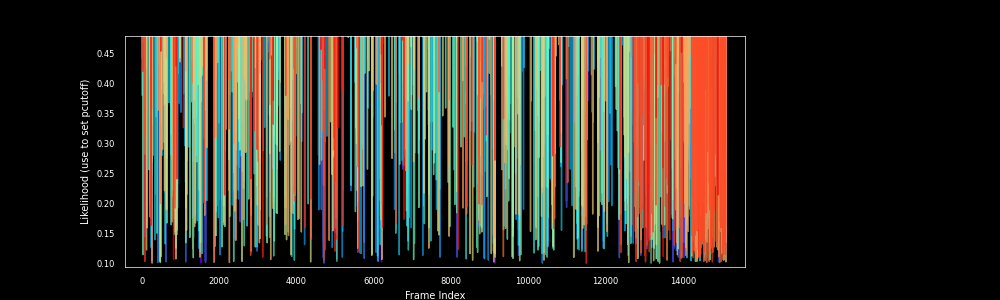

<IPython.core.display.Javascript object>


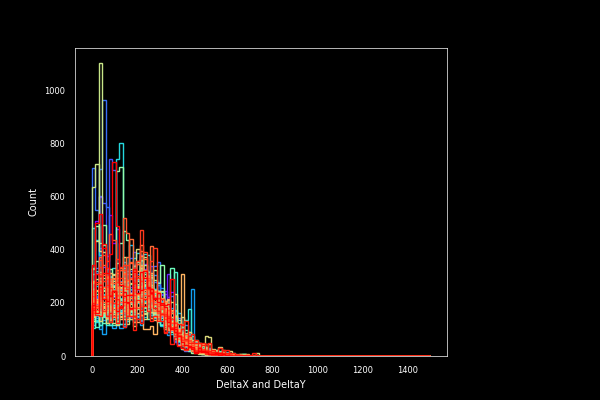

In [43]:
    """Plots poses vs time; pose x vs pose y; histogram of differences and likelihoods."""
    pcutoff = cfg["pcutoff"]
    colors = get_cmap(len(bodyparts2plot), name=cfg["colormap"])
    alphavalue = cfg["alphavalue"]
    if individuals2plot:
        Dataframe = Dataframe.loc(axis=1)[:, individuals2plot]
    animal_bpts = Dataframe.columns.get_level_values("bodyparts")
    # Pose X vs pose Y
    fig1 = pl.figure(figsize=(8, 6))
    ax1 = fig1.add_subplot(111)
    ax1.set_xlabel("X position in pixels")
    ax1.set_ylabel("Y position in pixels")
    ax1.invert_yaxis()

    # Poses vs time
    fig2 = pl.figure(figsize=(10, 3))
    ax2 = fig2.add_subplot(111)
    ax2.set_xlabel("Frame Index")
    ax2.set_ylabel("X-(dashed) and Y- (solid) position in pixels")

    # Likelihoods
    fig3 = pl.figure(figsize=(10, 3))
    ax3 = fig3.add_subplot(111)
    ax3.set_xlabel("Frame Index")
    ax3.set_ylabel("Likelihood (use to set pcutoff)")

    # Histograms
    fig4 = pl.figure()
    ax4 = fig4.add_subplot(111)
    ax4.set_ylabel("Count")
    ax4.set_xlabel("DeltaX and DeltaY")
    bins = np.linspace(0, np.amax(Dataframe.max()), 100)

    with np.errstate(invalid="ignore"):
        for bpindex, bp in enumerate(bodyparts2plot):
            if (
                bp in animal_bpts
            ):  # Avoid 'unique' bodyparts only present in the 'single' animal
                prob = Dataframe.xs(
                    (bp, "likelihood"), level=(-2, -1), axis=1
                ).values.squeeze()
                mask = prob < pcutoff
                temp_x = np.ma.array(
                    Dataframe.xs((bp, "x"), level=(-2, -1), axis=1).values.squeeze(),
                    mask=mask,
                )
                temp_y = np.ma.array(
                    Dataframe.xs((bp, "y"), level=(-2, -1), axis=1).values.squeeze(),
                    mask=mask,
                )
                ax1.plot(temp_x, temp_y, ".", color=colors(bpindex), alpha=alphavalue)

                ax2.plot(
                    temp_x,
                    "--",
                    color=colors(bpindex),
                    linewidth=linewidth,
                    alpha=alphavalue,
                )
                ax2.plot(
                    temp_y,
                    "-",
                    color=colors(bpindex),
                    linewidth=linewidth,
                    alpha=alphavalue,
                )

                ax3.plot(
                    prob,
                    "-",
                    color=colors(bpindex),
                    linewidth=linewidth,
                    alpha=alphavalue,
                )

                Histogram(temp_x, colors(bpindex), bins, ax4, linewidth=linewidth)
                Histogram(temp_y, colors(bpindex), bins, ax4, linewidth=linewidth)

    sm = pl.cm.ScalarMappable(
        cmap=pl.get_cmap(cfg["colormap"]),
        norm=pl.Normalize(vmin=0, vmax=len(bodyparts2plot) - 1),
    )
    sm._A = []
    for ax in ax1, ax2, ax3, ax4:
        cbar = pl.colorbar(sm, ax=ax, ticks=range(len(bodyparts2plot)))
        cbar.set_ticklabels(bodyparts2plot)


<IPython.core.display.Javascript object>


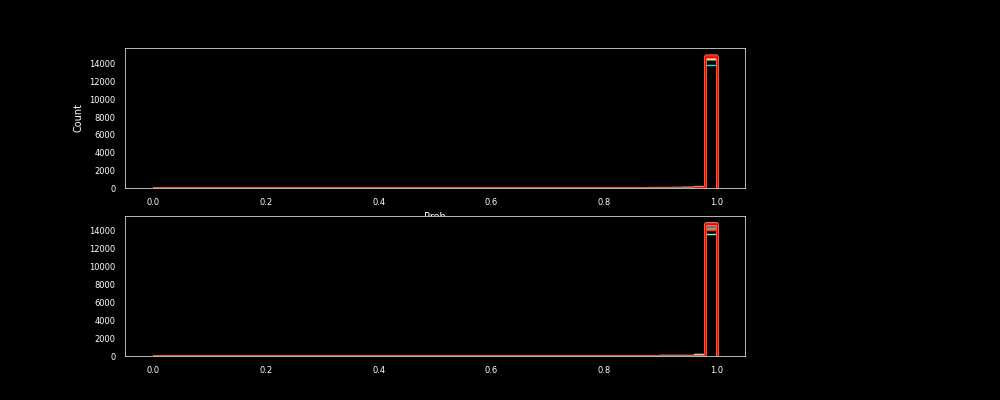

<IPython.core.display.Javascript object>


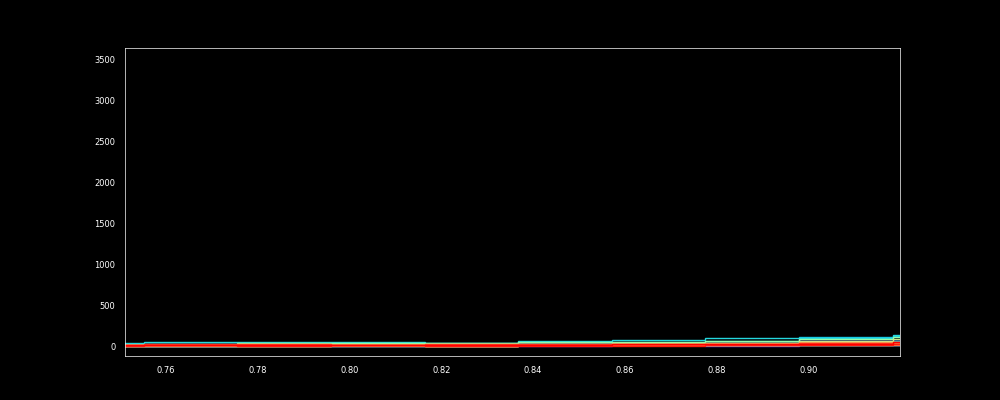

In [59]:

# Histograms
fig5 = pl.figure(figsize=(10,4))
ax5a = fig5.add_subplot(211)
ax5b = fig5.add_subplot(212)
ax5a.set_ylabel("Count")
ax5a.set_xlabel("Prob")
bins = np.linspace(0, 1, 50)

fig4 = pl.figure(figsize=(10,4))
ax4 = fig4.add_subplot(111)

with np.errstate(invalid="ignore"):
    for bpindex, bp in enumerate(bodyparts2plot):
        if (bp in animal_bpts):  # Avoid 'unique' bodyparts only present in the 'single' animal
            prob = Dataframe.xs(
                (bp, "likelihood"), level=(-2, -1), axis=1).values.squeeze()
            color = colors(bpindex)
            ax5a.hist(prob[:, 0], color=color, histtype="step", bins=bins, linewidth=linewidth)
            ax5b.hist(prob[:, 1], color=color, histtype="step", bins=bins, linewidth=linewidth)
            ax4.hist(prob.ravel(), color=color, histtype="step", bins=bins, linewidth=linewidth)

sm = pl.cm.ScalarMappable(
    cmap=pl.get_cmap(cfg["colormap"]),
    norm=pl.Normalize(vmin=0, vmax=len(bodyparts2plot) - 1),
)
sm._A = []
for ax in ax5a, ax5b:
    cbar = pl.colorbar(sm, ax=ax, ticks=range(len(bodyparts2plot)))
    cbar.set_ticklabels(bodyparts2plot)


In [45]:
prob

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [53]:
Dataframe.xs( (bp, 'likelihood'), level=(-2, -1), axis=1)

scorer      DLC_dlcrnetms5_MMFv2Sep27shuffle1_200000     
individuals                                     ind2 ind1
0                                                1.0  1.0
1                                                1.0  1.0
2                                                1.0  1.0
3                                                1.0  1.0
4                                                1.0  1.0
...                                              ...  ...
15113                                            1.0  1.0
15114                                            1.0  1.0
15115                                            1.0  1.0
15116                                            1.0  1.0
15117                                            1.0  1.0

[15118 rows x 2 columns]

In [41]:
colors(bpindex)

(0.5, 0.0, 1.0, 1.0)

In [36]:
individuals

TypeError: 'set' object is not subscriptable

<IPython.core.display.Javascript object>


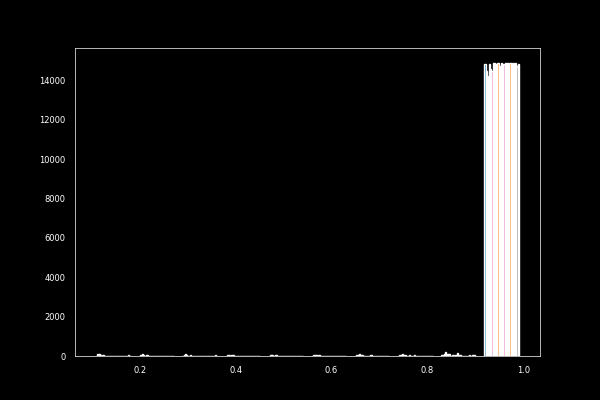

(array([[1.2000e+01, 4.0000e+00, 4.0000e+00, 5.0000e+00, 9.0000e+00,
         7.0000e+00, 1.4000e+01, 1.2000e+01, 3.5000e+01, 1.4809e+04],
        [1.1700e+02, 6.4000e+01, 5.0000e+01, 3.6000e+01, 4.5000e+01,
         4.4000e+01, 2.7000e+01, 3.7000e+01, 4.6000e+01, 1.4445e+04],
        [1.0700e+02, 8.1000e+01, 8.2000e+01, 7.2000e+01, 6.6000e+01,
         5.8000e+01, 6.8000e+01, 7.2000e+01, 1.0800e+02, 1.4197e+04],
        [7.0000e+01, 6.1000e+01, 5.8000e+01, 6.7000e+01, 7.0000e+01,
         6.4000e+01, 8.6000e+01, 1.0500e+02, 1.8700e+02, 1.4143e+04],
        [8.0000e+00, 8.0000e+00, 6.0000e+00, 2.0000e+00, 4.0000e+00,
         5.0000e+00, 7.0000e+00, 1.3000e+01, 1.0000e+01, 1.4848e+04],
        [3.0000e+01, 1.9000e+01, 2.0000e+01, 3.1000e+01, 2.9000e+01,
         3.3000e+01, 3.1000e+01, 5.6000e+01, 8.3000e+01, 1.4579e+04],
        [3.2000e+01, 3.3000e+01, 3.6000e+01, 4.2000e+01, 4.2000e+01,
         4.5000e+01, 4.5000e+01, 7.0000e+01, 8.7000e+01, 1.4479e+04],
        [5.0000e+00, 4.0000

In [39]:
ind2plot = list(individuals)[1]
    
df = df0.loc(axis=1)[:, ind2plot]
n_frames = df.shape[0]


xyp = df.values.reshape((n_frames, -1, 3))

fig, ax =pl.subplots()
ax.hist(xyp[:, :, 2])